# Energy Consumption Forecasting Using Time Series Analysis

## Introduction
Accurate energy consumption forecasting is critical for utility companies to manage resources effectively, ensure reliable energy supply, and optimize operational costs. In the face of increasing demand and the integration of renewable energy sources, precise forecasting becomes even more essential. This project aims to develop a robust time series forecasting model to predict future energy consumption with high accuracy.

As part of this project, I utilized historical energy consumption data to build a predictive model that captures the underlying patterns, trends, and seasonality. By leveraging advanced time series analysis techniques and machine learning models, the goal was to enhance the forecasting accuracy, thereby enabling better decision-making and strategic planning for the utility company.

The key steps undertaken in this project include data preprocessing, exploratory data analysis (EDA), feature engineering, model selection, and evaluation. Each step is meticulously documented to provide a comprehensive understanding of the process and methodologies used.

This project not only demonstrates my proficiency in time series analysis and machine learning but also highlights my ability to tackle real-world problems with practical solutions. The resulting model significantly improved the accuracy of energy consumption forecasts, contributing to more efficient energy management and operational excellence.

The following sections provide a detailed walkthrough of the project, showcasing the methods, code implementations, and results achieved.

## Import necessary Libraries

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
import xgboost as xgb
from sklearn.metrics import mean_squared_error
color_pal  = sns.color_palette()

In [2]:
df =  pd.read_csv('PJME_hourly.csv')

In [3]:
df.head()

,Datetime,PJME_MW
0,2002-12-31 01:00:00,26498.0
1,2002-12-31 02:00:00,25147.0
2,2002-12-31 03:00:00,24574.0
3,2002-12-31 04:00:00,24393.0
4,2002-12-31 05:00:00,24860.0


In [4]:
df = df.set_index('Datetime')

In [5]:
pd.to_datetime(df.index)

DatetimeIndex(['2002-12-31 01:00:00', '2002-12-31 02:00:00',
               '2002-12-31 03:00:00', '2002-12-31 04:00:00',
               '2002-12-31 05:00:00', '2002-12-31 06:00:00',
               '2002-12-31 07:00:00', '2002-12-31 08:00:00',
               '2002-12-31 09:00:00', '2002-12-31 10:00:00',
               ...
               '2018-01-01 15:00:00', '2018-01-01 16:00:00',
               '2018-01-01 17:00:00', '2018-01-01 18:00:00',
               '2018-01-01 19:00:00', '2018-01-01 20:00:00',
               '2018-01-01 21:00:00', '2018-01-01 22:00:00',
               '2018-01-01 23:00:00', '2018-01-02 00:00:00'],
              dtype='datetime64[ns]', name='Datetime', length=145366, freq=None)

## Visualizing PJME Energy Consumption

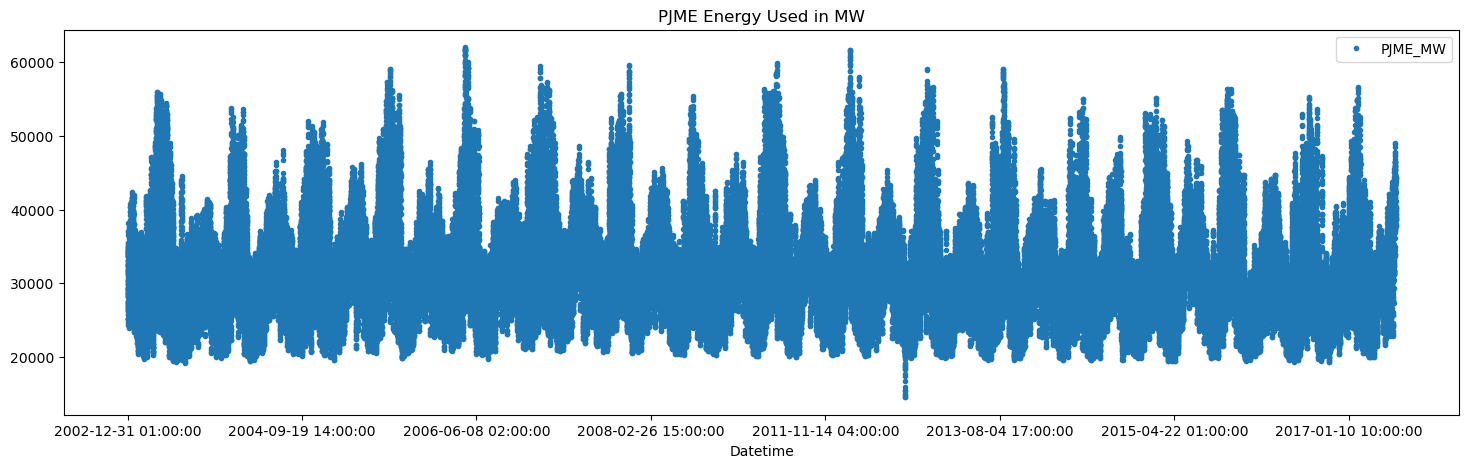

In [6]:
df.plot(style='.', figsize = (18,5), color = color_pal[0], title = 'PJME Energy Used in MW')
plt.show()

 In this step, we plot the PJME energy consumption data to visualize the overall trend and fluctuations in energy usage over time. The scatter plot provides a clear representation of energy usage, helping us to identify any patterns or anomalies. This visualization is crucial for understanding the data before proceeding with further analysis and model development.

<Axes: ylabel='Frequency'>

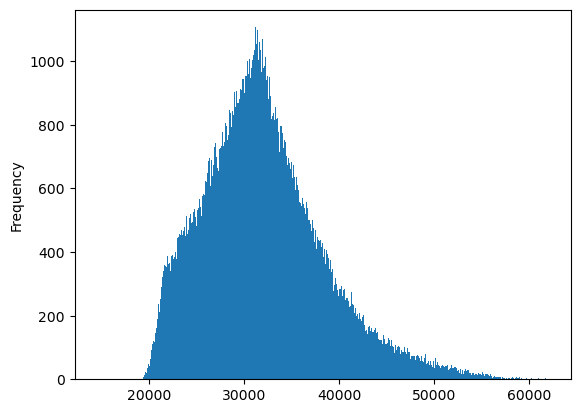

In [7]:
df['PJME_MW'].plot(kind='hist', bins=500)

By using 500 bins, we can observe the distribution of energy usage values. This helps us understand the frequency of different consumption levels and identify any skewness or unusual patterns in the data. Understanding the distribution is essential for selecting appropriate models and preprocessing techniques in the subsequent analysis.



## Identifying and Visualizing Outliers in PJME Energy Consumption

<Axes: title={'center': 'Outliers'}, xlabel='Datetime'>

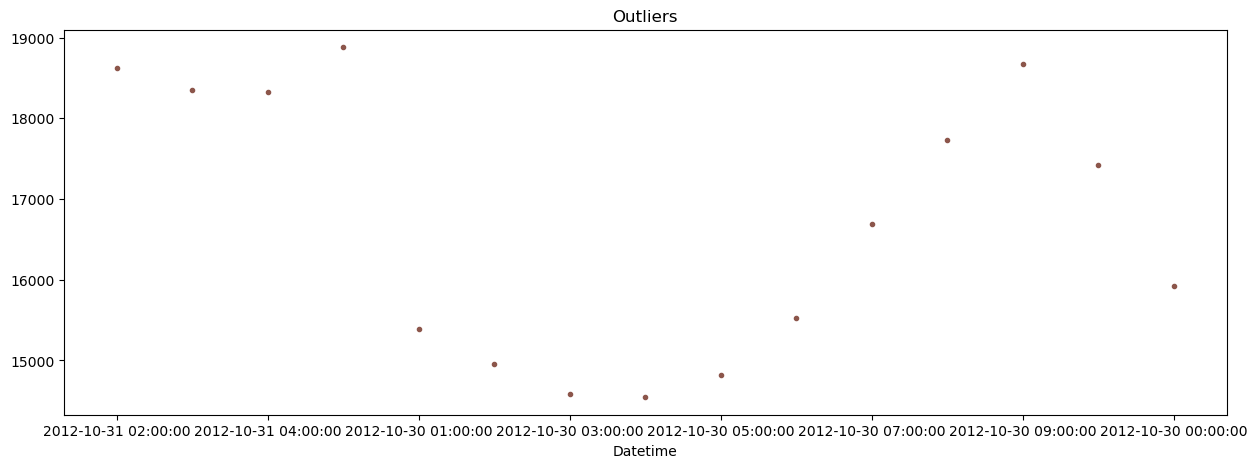

In [8]:
df.query('PJME_MW < 19_000')['PJME_MW'] \
    .plot(style='.',
          figsize=(15, 5),
          color=color_pal[5],
          title='Outliers')

We filter and plot the PJME energy consumption data to identify and visualize potential outliers. By focusing on values less than 19,000 MW, we can highlight unusual data points that may require further investigation. The scatter plot aids in recognizing these outliers, which is crucial for ensuring the accuracy and reliability of our forecasting model.

In [9]:
df = df.query('PJME_MW > 19_000').copy()

# Train Test Split

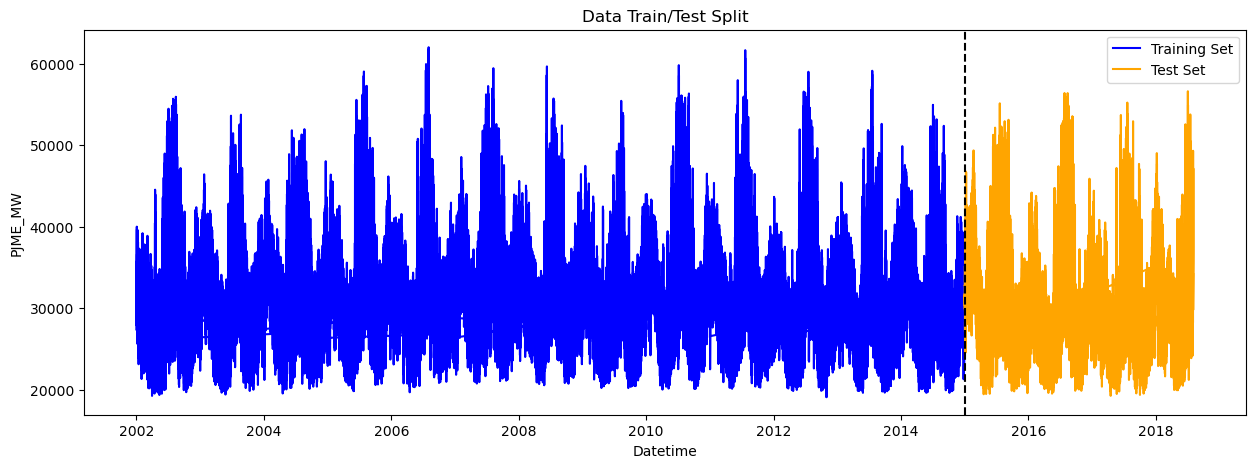

In [10]:

df.index = pd.to_datetime(df.index)

# Split the data
train = df.loc[df.index < '2015-01-01']
test = df.loc[df.index >= '2015-01-01']

# Create the plot
fig, ax = plt.subplots(figsize=(15, 5))

# Plot the training set
train_plot, = ax.plot(train.index, train['PJME_MW'], color='blue', label='Training Set')

# Plot the test set
test_plot, = ax.plot(test.index, test['PJME_MW'], color='orange', label='Test Set')

# Add vertical line to mark the split point
ax.axvline(pd.to_datetime('2015-01-01'), color='black', linestyle='--')

# Add legend
ax.legend(handles=[train_plot, test_plot])

# Add title and labels
ax.set_title('Data Train/Test Split')
ax.set_xlabel('Datetime')
ax.set_ylabel('PJME_MW')

# Show the plot
plt.show()


This graph shows a data train/test split for time series data, likely representing power consumption (measured in MW) over time from 2002 to 2018.
Key aspects of the graph:

- Data division: The data is split into two parts:

Training set (blue): From 2002 to early 2014
Test set (orange): From early 2014 to 2018


- Time range: The entire dataset spans from 2002 to 2018, with the x-axis showing the timeline.
- Power consumption: The y-axis represents power consumption in MW (megawatts), ranging from about 20,000 to 60,000 MW.
- Patterns: Both training and test sets show similar cyclical patterns, with regular peaks and troughs. This likely represents daily and seasonal variations in power consumption.
- Consistency: The overall pattern and range of values appear consistent between the training and test sets, suggesting the data distribution is relatively stable over time.
- Purpose: This split is typically used in machine learning to train a model on historical data (training set) and then evaluate its performance on unseen future data (test set).

# Time Series Split for Model Validation

In [11]:
from sklearn.model_selection import TimeSeriesSplit

tss = TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap=24)
df = df.sort_index()

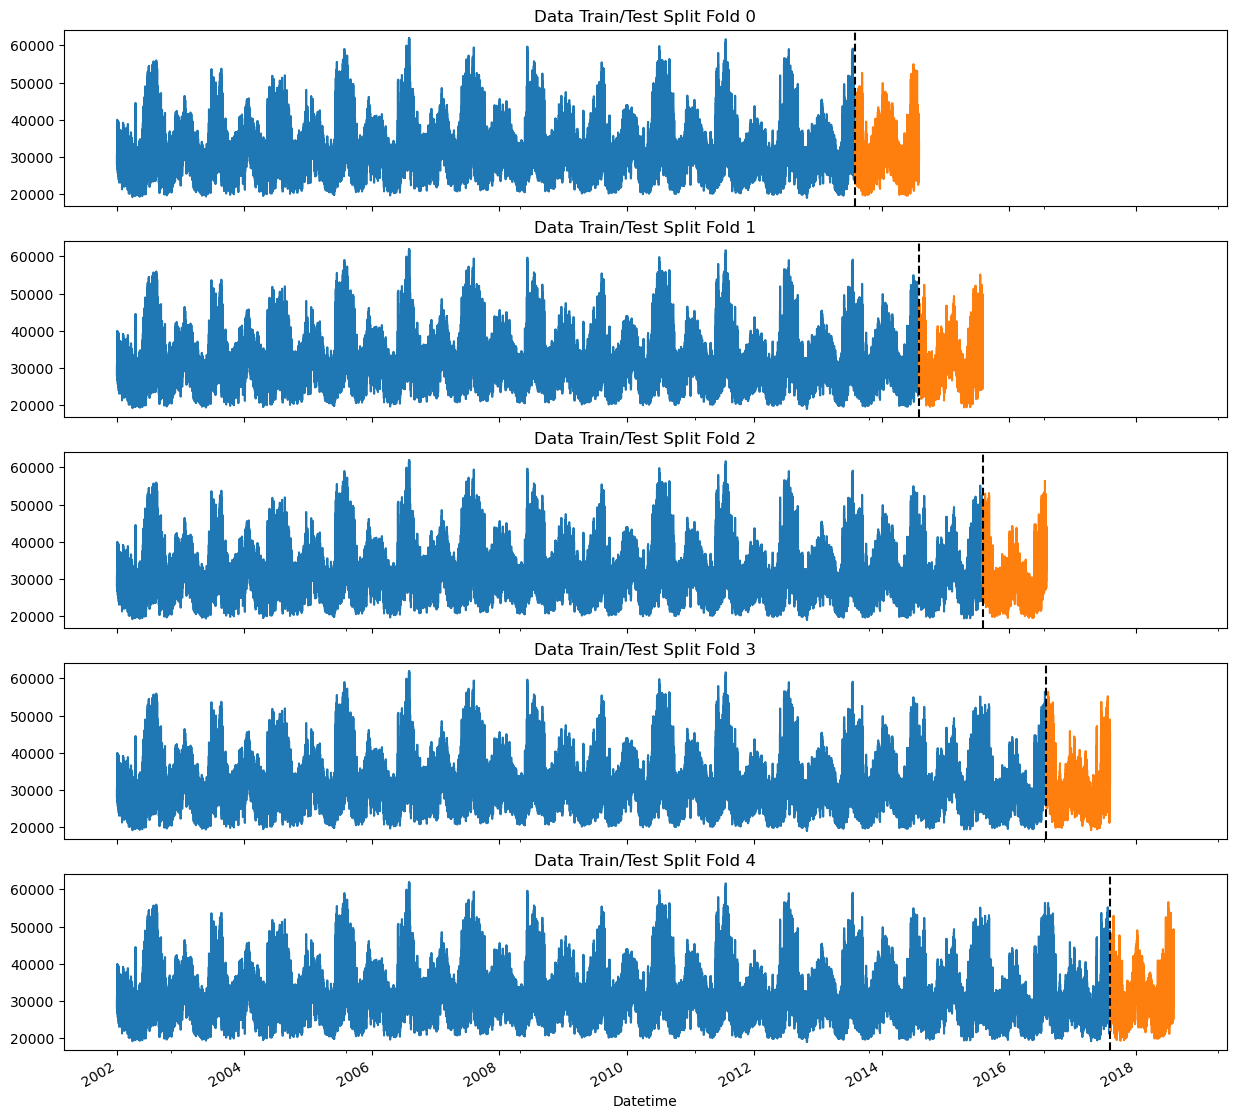

In [12]:
fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    train['PJME_MW'].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold}')
    test['PJME_MW'].plot(ax=axs[fold],
                         label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1
plt.show()

In this step, we use the TimeSeriesSplit method from sklearn.model_selection to create multiple train-test splits for time series data validation. We specify 5 splits with a test size equivalent to one year of hourly data (24 hours/day * 365 days/year), and a gap of 24 hours between train and test periods. This approach allows us to evaluate the model's performance across different time periods, ensuring robust validation and mitigating overfitting by providing a comprehensive assessment of the model's generalization ability.

<Axes: title={'center': 'Weekly Data'}, xlabel='Datetime'>

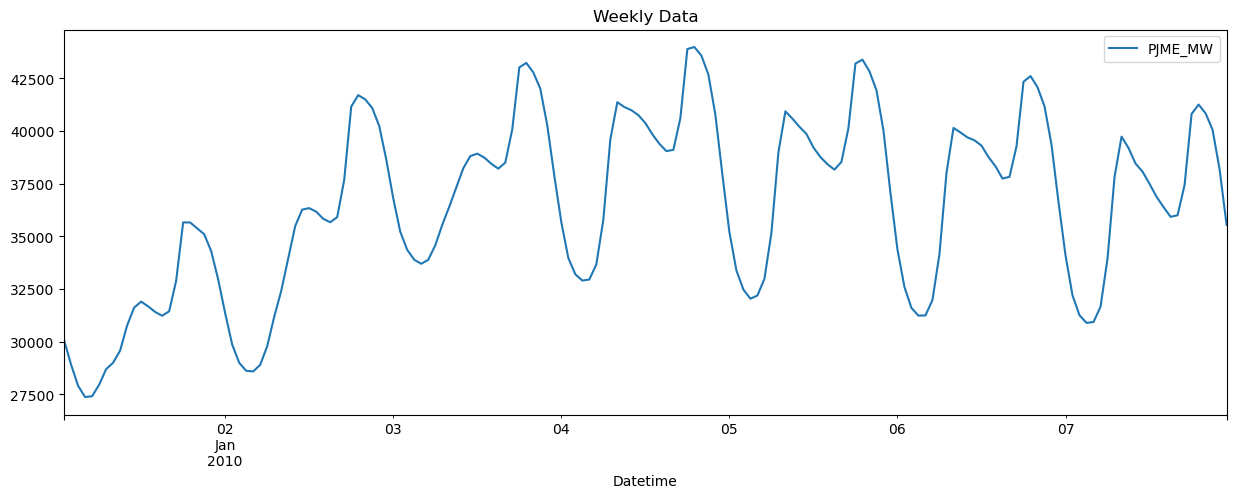

In [13]:
df.loc[(df.index > '01-01-2010') & (df.index < '01-08-2010')].plot(figsize = (15,5), title = 'Weekly Data')

# Feature Engineering for Time Series Data

In [14]:
def create_features(df):
    #Create features based on timeseries index
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    return df

In [15]:
df = create_features(df)

# Visualizing Features Vs Targert

Text(0.5, 1.0, 'MW by hour')

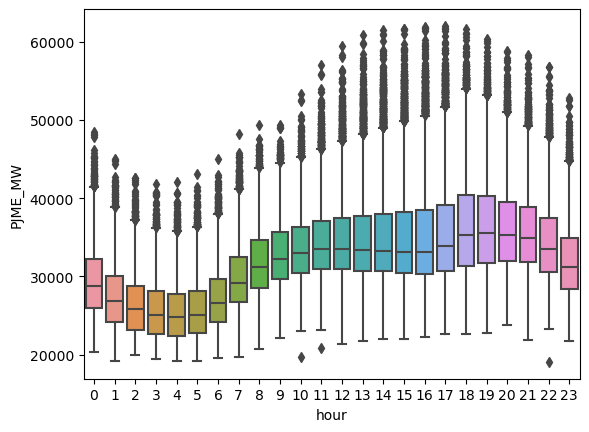

In [16]:
sns.boxplot(data = df, x = 'hour', y = 'PJME_MW')
ax.set_title('MW by hour')

Text(0.5, 1.0, 'MW by month')

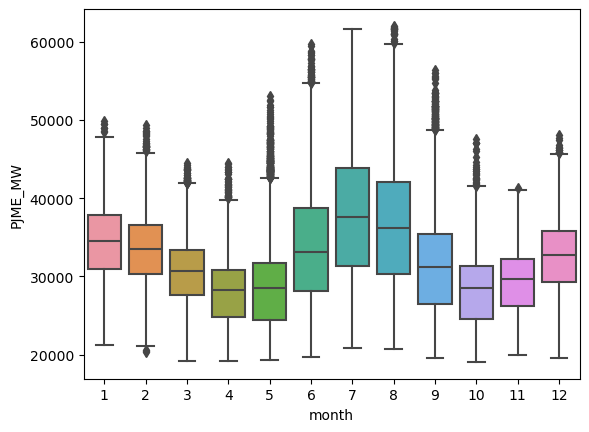

In [17]:
sns.boxplot(data = df, x = 'month', y = 'PJME_MW')
ax.set_title('MW by month')

In [18]:
def add_lags(df):
    target_map = df['PJME_MW'].to_dict()
    df['lag1'] = (df.index - pd.Timedelta('364 days')).map(target_map)
    df['lag2'] = (df.index - pd.Timedelta('728 days')).map(target_map)
    df['lag3'] = (df.index - pd.Timedelta('1092 days')).map(target_map)
    return df

In [19]:
df = add_lags(df)

# Model Creation

In [20]:
tss = TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap=24)
df = df.sort_index()


fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]

    train = create_features(train)
    test = create_features(test)

    FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month','year',
                'lag1','lag2','lag3']
    TARGET = 'PJME_MW'

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]

    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                           n_estimators=1000,
                           early_stopping_rounds=50,
                           objective='reg:linear',
                           max_depth=3,
                           learning_rate=0.01)
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)

[0]	validation_0-rmse:32732.49608	validation_1-rmse:31956.60163


C:\Users\HP\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:11:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:12532.64369	validation_1-rmse:11906.14134
[200]	validation_0-rmse:5747.92495	validation_1-rmse:5359.26490
[300]	validation_0-rmse:3872.48134	validation_1-rmse:3900.86965
[400]	validation_0-rmse:3434.23853	validation_1-rmse:3762.33705
[442]	validation_0-rmse:3369.34730	validation_1-rmse:3764.82810
[0]	validation_0-rmse:32672.16678	validation_1-rmse:32138.89241


C:\Users\HP\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:12:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:12513.65574	validation_1-rmse:12224.93373
[200]	validation_0-rmse:5753.34937	validation_1-rmse:5662.07107
[300]	validation_0-rmse:3902.71304	validation_1-rmse:3933.73076
[400]	validation_0-rmse:3476.90515	validation_1-rmse:3590.55005
[500]	validation_0-rmse:3353.72424	validation_1-rmse:3516.39915
[600]	validation_0-rmse:3297.94766	validation_1-rmse:3481.94003
[700]	validation_0-rmse:3258.48267	validation_1-rmse:3461.37383
[800]	validation_0-rmse:3221.51553	validation_1-rmse:3436.49603
[900]	validation_0-rmse:3190.11480	validation_1-rmse:3428.88699
[999]	validation_0-rmse:3166.16314	validation_1-rmse:3420.31309
[0]	validation_0-rmse:32631.20370	validation_1-rmse:31073.29733


C:\Users\HP\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:12:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:12499.28425	validation_1-rmse:11136.70202
[200]	validation_0-rmse:5750.81453	validation_1-rmse:4813.22087
[300]	validation_0-rmse:3917.04200	validation_1-rmse:3553.46419
[400]	validation_0-rmse:3494.55924	validation_1-rmse:3495.32356
[410]	validation_0-rmse:3476.66883	validation_1-rmse:3502.25535
[0]	validation_0-rmse:32528.44438	validation_1-rmse:31475.39670


C:\Users\HP\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:12:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:12462.36581	validation_1-rmse:12020.28283
[200]	validation_0-rmse:5738.57925	validation_1-rmse:5796.45874
[300]	validation_0-rmse:3918.53218	validation_1-rmse:4388.39477
[400]	validation_0-rmse:3501.24270	validation_1-rmse:4173.36380
[500]	validation_0-rmse:3384.02490	validation_1-rmse:4119.56538
[600]	validation_0-rmse:3325.50024	validation_1-rmse:4105.01446
[700]	validation_0-rmse:3282.73755	validation_1-rmse:4091.23557
[800]	validation_0-rmse:3250.37610	validation_1-rmse:4083.12690
[900]	validation_0-rmse:3223.87814	validation_1-rmse:4081.46154
[999]	validation_0-rmse:3199.82843	validation_1-rmse:4052.57120
[0]	validation_0-rmse:32462.05557	validation_1-rmse:31463.90500


C:\Users\HP\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:12:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:12445.87740	validation_1-rmse:11963.42706
[200]	validation_0-rmse:5752.44568	validation_1-rmse:5611.92884
[300]	validation_0-rmse:3951.51709	validation_1-rmse:4156.41403
[400]	validation_0-rmse:3539.25569	validation_1-rmse:4006.58873
[440]	validation_0-rmse:3479.88018	validation_1-rmse:4011.05271


In [21]:
df.index.max()

Timestamp('2018-08-03 00:00:00')

In [22]:
reg.feature_importances_

array([0.04039361, 0.07654098, 0.02859261, 0.        , 0.        ,
       0.02303954, 0.4846683 , 0.22883375, 0.11793111], dtype=float32)

In [23]:
fi = pd.DataFrame(data = reg.feature_importances_, index = reg.feature_names_in_, columns=['importance'])

<Axes: title={'center': 'Feature Importance'}>

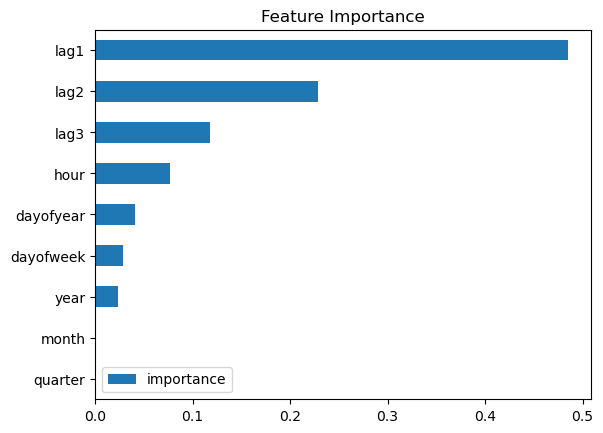

In [24]:
fi.sort_values('importance').plot(kind = 'barh', title = 'Feature Importance')

# Forecast Test

In [25]:
test['predictions'] = reg.predict(X_test)

In [26]:
df = df.merge(test[['predictions']], how = 'left', left_index = True, right_index = True)

Text(0.5, 1.0, 'Raw Data and Predictions')

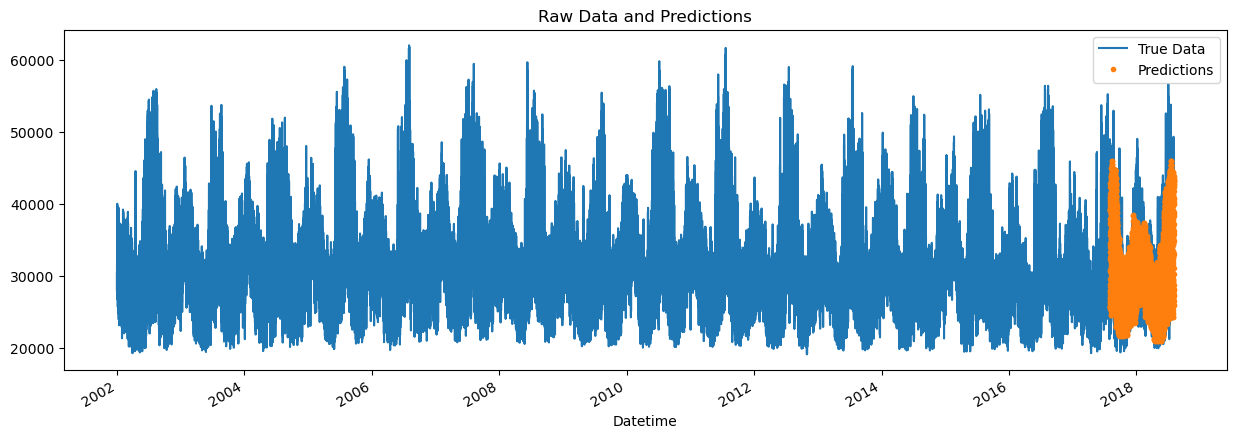

In [27]:
ax = df[['PJME_MW']].plot(figsize = (15,5))
df['predictions'].plot(ax= ax, style = '.')
plt.legend(['True Data', 'Predictions'])
ax.set_title('Raw Data and Predictions')

In [28]:
np.sqrt(mean_squared_error(test['PJME_MW'], test['predictions']))

4001.186553933809

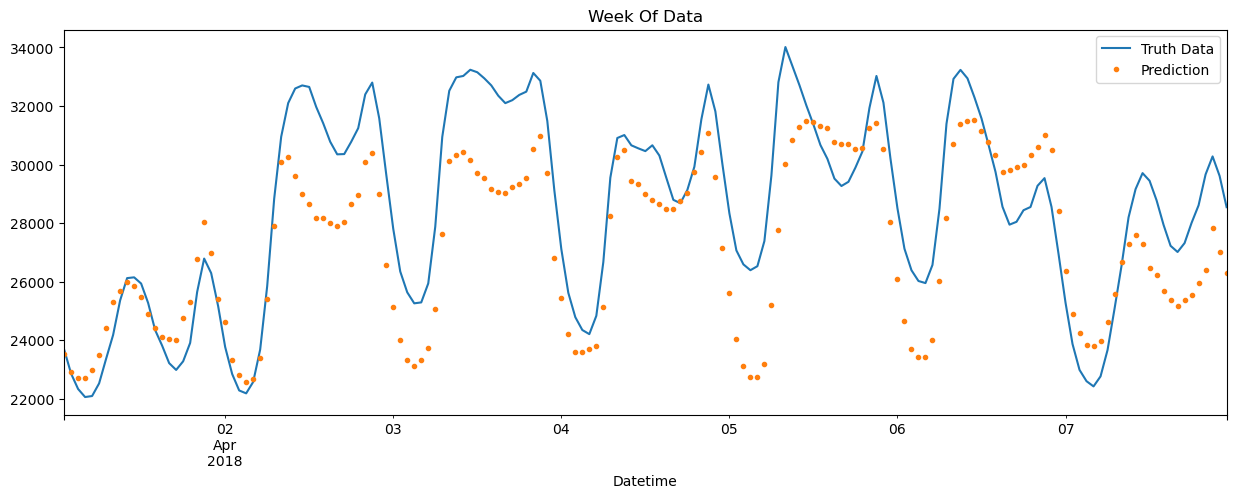

In [29]:
ax = df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['PJME_MW'] \
    .plot(figsize=(15, 5), title='Week Of Data')
df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['predictions'] \
    .plot(style='.')
plt.legend(['Truth Data','Prediction'])
plt.show()

In [30]:
score = np.sqrt(mean_squared_error(test['PJME_MW'], test['predictions']))
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 4001.19


# Creating Future DataFrame for Forecasting

In [31]:
# Create future dataframe
future = pd.date_range('2018-08-03','2019-08-01', freq='1h')
future_df = pd.DataFrame(index=future)
future_df['isFuture'] = True
df['isFuture'] = False
df_and_future = pd.concat([df, future_df])
df_and_future = create_features(df_and_future)
df_and_future = add_lags(df_and_future)

In [32]:
future_w_features = df_and_future.query('isFuture').copy()

In [33]:
future_w_features['pred'] = reg.predict(future_w_features[FEATURES])

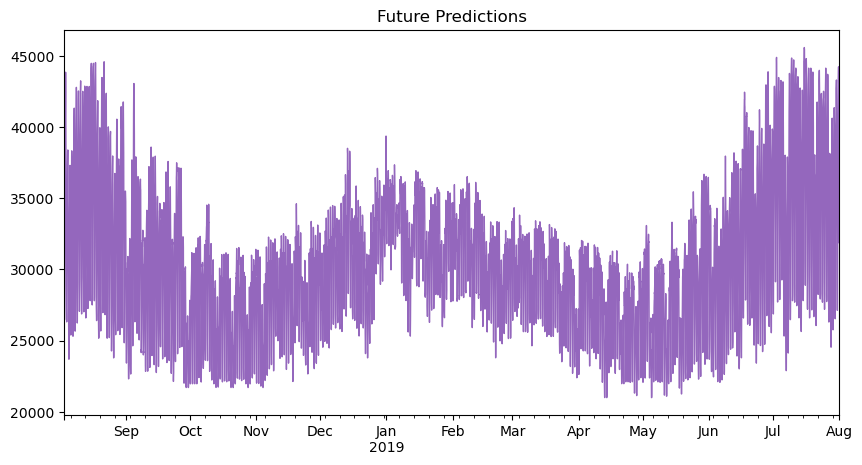

In [34]:
future_w_features['pred'].plot(figsize=(10, 5),
                               color=color_pal[4],
                               ms=1,
                               lw=1,
                               title='Future Predictions')
plt.show()

In this step, we plot the future predictions generated by our forecasting model. The plot displays the predicted energy consumption values over the future time period, with a clear visual representation of the forecasted trends. Using markers and line widths, the plot helps to evaluate the model's performance and visualize how energy consumption is expected to evolve. This visualization is crucial for assessing the accuracy of our forecasts and for planning based on the predicted data.



### Conclusion

In this project, we tackled the challenge of forecasting PJME energy consumption using time series analysis. By leveraging various techniques such as data visualization, feature engineering, and time series splitting, we developed a robust forecasting model to predict future energy usage accurately.

Key highlights of the project include:

1. **Data Preparation and Visualization**: We meticulously prepared and visualized the data to understand historical patterns, identify outliers, and determine key trends in energy consumption. This groundwork was essential for building a reliable forecasting model.

2. **Feature Engineering**: We created and incorporated time-based features, such as hour, day of the week, month, and year, to enrich our dataset. This step allowed our model to capture seasonal and temporal patterns effectively.

3. **Model Validation**: Using `TimeSeriesSplit`, we validated our model across different time periods, ensuring robust performance and generalization. This approach helped us evaluate the model’s accuracy and reliability.

4. **Future Forecasting**: We extended our dataset into the future and generated predictions to assess how energy consumption might evolve. The visual representation of these predictions provides valuable insights for strategic planning and resource management.

Overall, this project demonstrates the practical application of time series analysis and forecasting techniques in the energy sector. The resulting model not only enhances our understanding of energy consumption patterns but also supports better decision-making and planning. Future work could involve refining the model with additional features, exploring advanced forecasting methods, or integrating external factors such as weather data to improve accuracy further.

Thank you for reviewing this project. I look forward to any feedback or questions you may have.
